In [5]:
import pandas as pd
import networkx as nx
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import stats
from collections import deque

In [6]:
"""
for google colab support
"""

from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/BA/SIPandemic'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['Kopie von SI-Pandemic.ipynb', 'PandemicSIDynamic.ipynb']


In [11]:
# Load CSV files
current_directory = os.getcwd()

# Navigate one folder up
parent_directory = os.path.dirname(current_directory)

# Construct the path to the "CSV-Files" folder
csv_files_folder = os.path.join(parent_directory, "CSV-Files ")

file_path = os.path.join(csv_files_folder, "cities.csv")

cities_df = pd.read_csv(file_path, index_col='City')

file_path = os.path.join(csv_files_folder, "edges.csv")

edges_df = pd.read_csv(file_path)

file_path = os.path.join(csv_files_folder, "node_positions.csv")

positions_df = pd.read_csv(file_path, index_col='City')

file_path = os.path.join(csv_files_folder, "disease_counters.csv")

disease_counters_df = pd.read_csv(file_path, index_col='City')

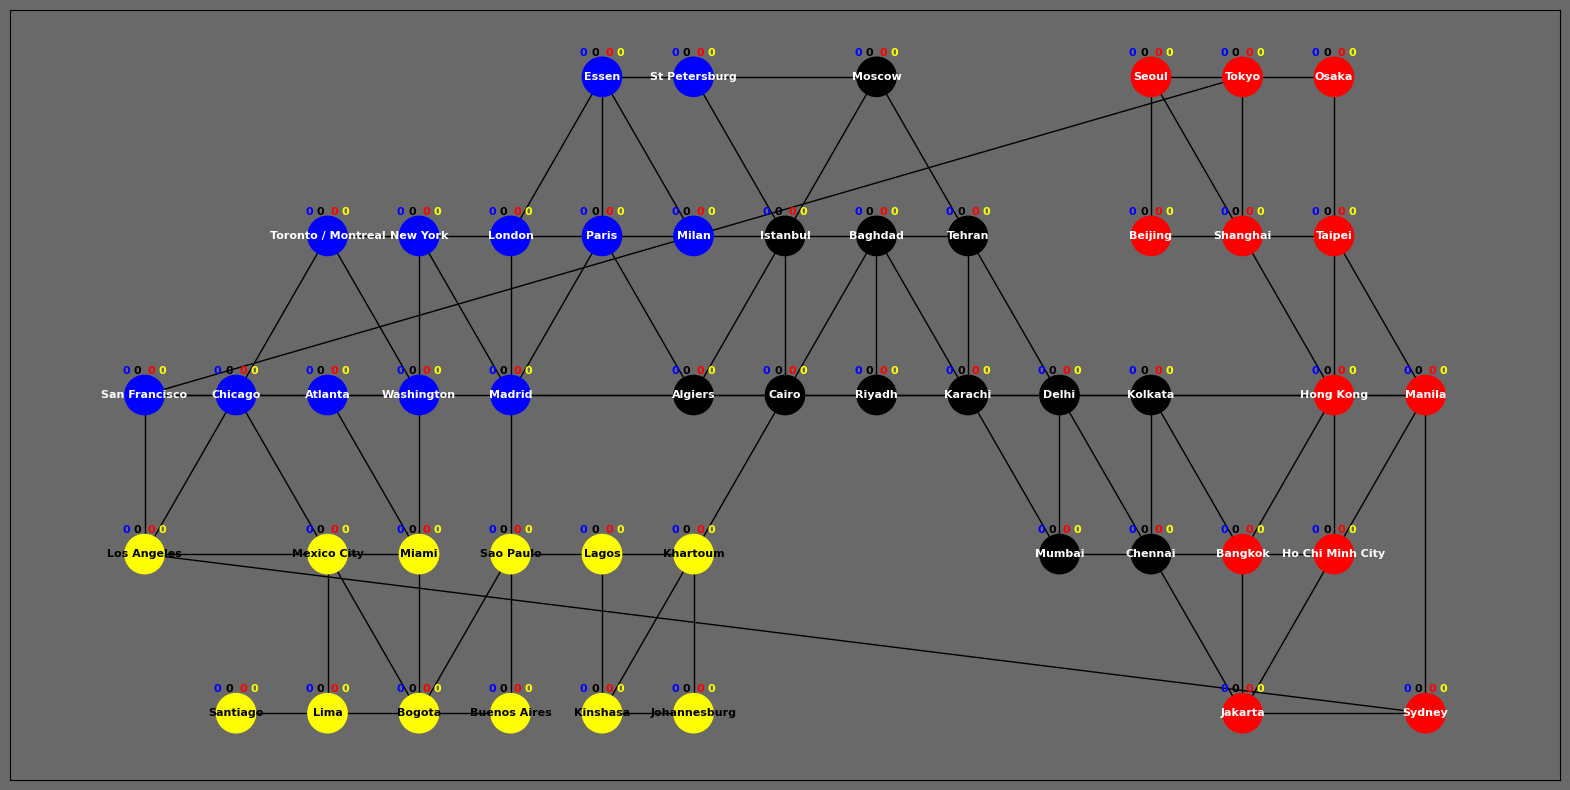

In [12]:
# Create an empty graph
Graph_gameboard = nx.Graph()

# Add nodes with attributes
for city, color in cities_df['Color'].items():
    Graph_gameboard.add_node(city, color=color)

# Add edges from DataFrame
Graph_gameboard.add_edges_from(edges_df.values)

# Set node attributes for disease counters
for city, counters in disease_counters_df.iterrows():
    Graph_gameboard.nodes[city]['disease_counters'] = counters.to_dict()

# Define node positions
node_positions = positions_df.apply(tuple, axis=1).to_dict()

fig, ax = plt.subplots(figsize=(20, 10))

node_colors = [cities_df.loc[city, 'Color'] for city in Graph_gameboard.nodes()]

# change font of nodes with yellow color
yellow_nodes = [city for city, color in cities_df['Color'].items() if color == 'yellow']
font_colors = {city: 'black' if city in yellow_nodes else 'white' for city in Graph_gameboard.nodes()}

# Draw the nodes
nx.draw_networkx_nodes(Graph_gameboard, pos=node_positions, node_color=node_colors, node_size=800)

# Draw the edges
nx.draw_networkx_edges(Graph_gameboard, pos=node_positions)

# Add labels manually with specified colors
for node, (x, y) in node_positions.items():
    plt.text(x, y, node, fontsize=8, ha='center', va='center', color=font_colors[node], weight='bold')

ax.set_facecolor('#696969')
fig.set_facecolor('#696969')

font_colors_city_names = {city: 'black' if city in yellow_nodes else 'white' for city in Graph_gameboard.nodes()}

for node, (x, y) in node_positions.items():
    counters = Graph_gameboard.nodes[node]['disease_counters']

    # Construct labels for each counter with its color
    blue_label = f"{counters['blue']}"
    black_label = f"{counters['black']}"
    red_label = f"{counters['red']}"
    yellow_label = f"{counters['yellow']}"

    # Draw the text for each counter with its color
    plt.text(x - 4, y + 3, blue_label, fontsize=8, ha='center', va='center', color='blue', weight='bold')
    plt.text(x - 1.5, y + 3, black_label, fontsize=8, ha='center', va='center', color='black', weight='bold')
    plt.text(x + 1.5, y + 3, red_label, fontsize=8, ha='center', va='center', color='red', weight='bold')
    plt.text(x + 4, y + 3, yellow_label, fontsize=8, ha='center', va='center', color='yellow', weight='bold')

plt.show()

In [13]:
#@title initialize_pandemic_model
# Initialize the infected cities and the infection_discard_stack, infection_stack, player_stack
def initialize_pandemic_model(graph, strategy, k_action = 4, epidemic_cards = 6, nodes_to_infect_at_start = 3):
    # 96 Cubes 24 in 4 Colors
    # 48 cities
    # 6 Epidemic card
    # Infection rate 7 tiles, (2,2,2,3,3,4,4)
    # Outbreak marker 8 tiles

    # Get and shuffle all Nodes
    num_nodes = graph.number_of_nodes()
    all_nodes = list(graph.nodes)
    random.shuffle(all_nodes)

    # Initialize stacks
    infection_discard_stack = deque()
    infection_stack = deque(all_nodes)
    player_stack = deque()

    # k Nodes to infect at the start (Pandemic normal value is 3x3, 3x2, 3x1 total 9 nodes)
    # Needs to be set to 3 so we do 3 times the different infection counts
    k_nodes_to_infect = nodes_to_infect_at_start

    # Set the amount of epidemic cards (4,5,6 Pandemic)
    epidemics = epidemic_cards

    infection_rate = [2, 2, 2, 3, 3, 4, 4]
    infection_rate_counter = 0
    outbreak_counter = 0

    k_actions = k_action

    # Set the disinfection strategy
    disinfection_strategy = strategy

    # -------------------------------
    # Start of Epidemic Cards Setup
    # -------------------------------
    if not epidemics == 0:

        # Calculate the chunk size for the epidemics (Floor division)
        chunk_size = num_nodes // epidemics

        # Add chunks with one epidemic node to the player deck
        for i in range(epidemics):
            if i == epidemics - 1:
                chunk = random.sample(all_nodes, len(all_nodes))
            else:
                chunk = random.sample(all_nodes, chunk_size)

            chunk.extend(["Epidemic"])
            random.shuffle(chunk)
            player_stack.extend(chunk)

            # Remove nodes used in this chunk
            all_nodes = list(set(all_nodes) - set(chunk))
    else:
        chunk = random.sample(all_nodes, len(all_nodes))
        random.shuffle(chunk)
        player_stack.extend(chunk)

    #while (epidemics == 1 or epidemics == 2) and player_stack[-1] == "Epidemic":
        #random.shuffle(player_stack)

    # Shuffle the deque in-place
    #random.shuffle(player_stack)
    # -------------------------------
    # End of Epidemic Cards Setup
    # -------------------------------

    # -------------------------------
    # Start of Node infection
    # -------------------------------

    # Infect k nodes with 3 disease counters (blue)
    for _ in range(k_nodes_to_infect):
        node = infection_stack.pop()
        graph.nodes[node]["disease_counters"]["blue"] = 3
        infection_discard_stack.append(node)

    # Infect k nodes with 2 disease counters (blue)
    for _ in range(k_nodes_to_infect):
        node = infection_stack.pop()
        graph.nodes[node]["disease_counters"]["blue"] = 2
        infection_discard_stack.append(node)

    # Infect k nodes with 1 disease counter (blue)
    for _ in range(k_nodes_to_infect):
        node = infection_stack.pop()
        graph.nodes[node]["disease_counters"]["blue"] = 1
        infection_discard_stack.append(node)

    # Set the remaining nodes to have 0 disease counters
    for node in infection_stack:
        graph.nodes[node]["disease_counters"]["blue"] = 0

    # -------------------------------
    # End of Node infection
    # -------------------------------

    # Set node attributes
    #nx.set_node_attributes(graph, 0, "disease_counters")

    # Initialize the sisr_model
    pandemic_model = {"graph": graph,
                      "infection_stack": infection_stack,
                      "infection_discard_stack": infection_discard_stack,
                      "player_stack": player_stack,
                      "infection_rate": infection_rate,
                      "infection_rate_counter": infection_rate_counter,
                      "outbreak_counter": outbreak_counter,
                      "disinfection_strategy": disinfection_strategy,
                      "k_actions": k_actions,
                      "epidemic_cards": epidemics,
                      "nodes_to_infect_at_start": nodes_to_infect_at_start}

    return pandemic_model

In [14]:
#@title Outbreak
# Outbreak logi
def outbreak(graph, node, color, outbreak_nodes=None, outbreak_counter=0):

    # Set of Nodes that had an Outbreak (1 Outbreak per iteration)
    if outbreak_nodes is None:
        outbreak_nodes = set()  # Initialize the set of nodes that have had an outbreak
    outbreak_nodes.add(node)  # Add the current node to the set

    connected_nodes = graph.neighbors(node)
    #print(connected_nodes)

    # Infect every neighbour
    for cn in connected_nodes:
        if cn not in outbreak_nodes:  # Only process the node if it hasn't had an outbreak yet
            if(graph.nodes[cn]['disease_counters'][color] == 3):
                outbreak(graph, cn, color, outbreak_nodes, outbreak_counter + 1)
            else:
                graph.nodes[cn]['disease_counters'][color] += 1

    return outbreak_counter

# **Disinfect**

---

In [15]:
#@title Strategy 0: Baseline disinfect
def baseline_disinfection(graph, k):
    pass

In [ ]:
#@title Strategy 1: Randomly Disinfect Nodes (one Cube per Node per Turn)
def random_disinfection(graph, k):
    # Randomly disinfect k nodes with a blue disease counter greater than 0
    nodes_to_disinfect = [node for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] > 0]
    nodes_to_disinfect = random.sample(nodes_to_disinfect, min(k, len(nodes_to_disinfect)))

    for node in nodes_to_disinfect:
        graph.nodes[node]["disease_counters"]["blue"] -= 1

In [ ]:
#@title Strategy 1: Randomly Disinfect Nodes (Nodes can repeat)
def random_disinfection_repeat(graph, k):
    # Get nodes with a blue disease counter greater than 0
    nodes_to_disinfect = [node for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] > 0]

    # Initialize disinfection count
    disinfection_count = 0

    while nodes_to_disinfect and disinfection_count < k:
        # Randomly select a node to disinfect
        node_to_disinfect = random.choice(nodes_to_disinfect)

        # Decrease the disease counter for the selected node
        graph.nodes[node_to_disinfect]["disease_counters"]["blue"] -= 1

        # Increment disinfection count
        disinfection_count += 1

        # If the counter becomes 0, remove the node from the list
        if graph.nodes[node_to_disinfect]["disease_counters"]["blue"] == 0:
            nodes_to_disinfect.remove(node_to_disinfect)

In [ ]:
#@title Strategy 2: Disinfect Nodes with Most Cubes

def disinfect_most_cubes(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] > 0]

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=lambda node: graph.nodes[node]["disease_counters"]["blue"], reverse=True)
    nodes_to_disinfect = nodes_to_disinfect[:k]

    for node in nodes_to_disinfect:
        graph.nodes[node]["disease_counters"]["blue"] -= 1

In [ ]:
#@title Strategy 2: Disinfect Nodes with Most Cubes (Nodes can repeat)
def disinfect_most_cubes_repeat(graph, k):
    # Get nodes with a blue disease counter greater than 0
    nodes_to_disinfect = [node for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] > 0]

    # Sort nodes by blue disease counter
    nodes_to_disinfect = sorted(nodes_to_disinfect, key=lambda node: graph.nodes[node]["disease_counters"]["blue"], reverse=True)

    # Initialize disinfection count
    disinfection_count = 0

    while nodes_to_disinfect and disinfection_count < k:
        # Select the node with the most cubes
        node_to_disinfect = nodes_to_disinfect[0]

        graph.nodes[node_to_disinfect]["disease_counters"]["blue"] -= 1

        disinfection_count += 1

        # If the counter becomes 0, remove the node from the list
        if graph.nodes[node_to_disinfect]["disease_counters"]["blue"] == 0:
            nodes_to_disinfect.remove(node_to_disinfect)

        nodes_to_disinfect.sort(key=lambda node: graph.nodes[node]["disease_counters"]["blue"], reverse=True)

In [ ]:
#@title Strategy 3: Disinfect Nodes with Highest Degree

def disinfect_highest_degree(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] > 0]

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=lambda node: graph.degree[node], reverse=True)
    nodes_to_disinfect = nodes_to_disinfect[:k]

    for node in nodes_to_disinfect:
        graph.nodes[node]["disease_counters"]["blue"] -= 1

In [ ]:
#@title Strategy 3: Disinfect Nodes with Highest Degree (repeat)

def disinfect_highest_degree_repeat(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] > 0]

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=lambda node: graph.degree[node], reverse=True)

    disinfection_count = 0

    while nodes_to_disinfect and disinfection_count < k:
        node_to_disinfect = nodes_to_disinfect[0]

        graph.nodes[node_to_disinfect]["disease_counters"]["blue"] -= 1

        disinfection_count += 1

        if graph.nodes[node_to_disinfect]["disease_counters"]["blue"] == 0:
            nodes_to_disinfect.remove(node_to_disinfect)

        nodes_to_disinfect.sort(key=lambda node: graph.degree[node], reverse=True)

In [ ]:
#@title Strategy 4: Combination of Most Cubes and Highest Degree (only sort)

def disinfect_combined(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] > 0]

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=lambda node: (graph.nodes[node]["disease_counters"]["blue"], graph.degree[node]), reverse=True)
    nodes_to_disinfect = nodes_to_disinfect[:k]

    for node in nodes_to_disinfect:
        graph.nodes[node]["disease_counters"]["blue"] -= 1

In [ ]:
#@title Strategy 4: Combination of Most Cubes and Highest Degree (only sort)(repeat)

def disinfect_combined_repeat(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] > 0]

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=lambda node: (graph.nodes[node]["disease_counters"]["blue"], graph.degree[node]), reverse=True)

    disinfection_count = 0

    while nodes_to_disinfect and disinfection_count < k:
        node_to_disinfect = nodes_to_disinfect[0]

        graph.nodes[node_to_disinfect]["disease_counters"]["blue"] -= 1

        disinfection_count += 1

        if graph.nodes[node_to_disinfect]["disease_counters"]["blue"] == 0:
            nodes_to_disinfect.remove(node_to_disinfect)

        nodes_to_disinfect.sort(key=lambda node: (graph.nodes[node]["disease_counters"]["blue"], graph.degree[node]), reverse=True)

In [ ]:
#@title Strategy 5: Combination of Most Cubes and Highest Degree (SUM function)

def disinfect_combined_sum(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] > 0]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(5, graph.degree[node])
        disease_score = min(3, graph.nodes[node]["disease_counters"]["blue"])
        return degree_score + disease_score

    # Sort the nodes based on the score
    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)
    nodes_to_disinfect = nodes_to_disinfect[:k]

    for node in nodes_to_disinfect:
        graph.nodes[node]["disease_counters"]["blue"] -= 1


In [ ]:
#@title Strategy 5: Combination of Most Cubes and Highest Degree (SUM function)(repeat)
def disinfect_combined_sum_repeat(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] > 0]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(5, graph.degree[node])
        disease_score = min(3, graph.nodes[node]["disease_counters"]["blue"])
        return degree_score + disease_score

    disinfection_count = 0

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)

    while nodes_to_disinfect and disinfection_count < k:
        node_to_disinfect = nodes_to_disinfect[0]

        graph.nodes[node_to_disinfect]["disease_counters"]["blue"] -= 1

        disinfection_count += 1

        if graph.nodes[node_to_disinfect]["disease_counters"]["blue"] == 0:
            nodes_to_disinfect.remove(node_to_disinfect)

        # Sort the nodes based on the score
        nodes_to_disinfect.sort(key=calculate_score, reverse=True)

In [ ]:
#@title Strategy 6: Combination of Most Cubes and Highest Degree (MUL function)
def disinfect_combined_mul(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] > 0]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(5, graph.degree[node])
        disease_score = min(3, graph.nodes[node]["disease_counters"]["blue"])
        return degree_score * disease_score

    # Sort the nodes based on the score
    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)
    nodes_to_disinfect = nodes_to_disinfect[:k]

    for node in nodes_to_disinfect:
        graph.nodes[node]["disease_counters"]["blue"] -= 1


In [ ]:
#@title Strategy 6: Combination of Most Cubes and Highest Degree (MUL function)(repeat)
def disinfect_combined_mul_repeat(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] > 0]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(5, graph.degree[node])
        disease_score = min(3, graph.nodes[node]["disease_counters"]["blue"])
        return degree_score * disease_score

    disinfection_count = 0

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)

    while nodes_to_disinfect and disinfection_count < k:
        node_to_disinfect = nodes_to_disinfect[0]

        graph.nodes[node_to_disinfect]["disease_counters"]["blue"] -= 1

        disinfection_count += 1

        if graph.nodes[node_to_disinfect]["disease_counters"]["blue"] == 0:
            nodes_to_disinfect.remove(node_to_disinfect)

        # Sort the nodes based on the score
        nodes_to_disinfect.sort(key=calculate_score, reverse=True)

# **Simulation and CSV creation
**

---

In [23]:
#@title Simulation and CSV creation

def simulate_pandemic(model, num_steps, run):
    graph = model["graph"]  # Get the graph and stacks from the model
    infection_stack = model["infection_stack"]
    infection_discard_stack = model["infection_discard_stack"]
    player_stack = model["player_stack"]
    infection_rate = model["infection_rate"] # [2, 2, 2, 3, 3, 4, 4]
    infection_rate_counter = model["infection_rate_counter"]
    outbreak_counter = model["outbreak_counter"]
    disinfection_strategy = model["disinfection_strategy"]
    k_actions = model["k_actions"]
    epidemics = model["epidemic_cards"]
    nodes_to_infect_at_start = model["nodes_to_infect_at_start"]

    # Initialize lists to store statistics for each step
    statistics = []
    epidemic_counter = 0
    player_deck_empty  = False

    # Add the init step to the CSV-file
    statistics.append({
        'setup': disinfection_strategy,
        'run': run,  # Index of simulation run
        'k_actions': k_actions,
        'timestep': -1,
        'susceptible_nodes': sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 0),
        'infection_1_nodes': sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 1),
        'infection_2_nodes': sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 2),
        'infection_3_nodes': sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 3),
        'outbreaks': outbreak_counter,
        'deck_empty': player_deck_empty,
        'player_stack': len(player_stack),
    })

    for step in range(num_steps):
        # Perform actions (disinfection)
        if disinfection_strategy == "baseline":
            baseline_disinfection(graph, k_actions)
        elif disinfection_strategy == "random":
            random_disinfection(graph, k_actions)
        elif disinfection_strategy == "random_repeat":
            random_disinfection_repeat(graph, k_actions)
        elif disinfection_strategy == "most_cubes":
            disinfect_most_cubes(graph, k_actions)
        elif disinfection_strategy == "most_cubes_repeat":
            disinfect_most_cubes_repeat(graph, k_actions)
        elif disinfection_strategy == "highest_degree":
            disinfect_highest_degree(graph, k_actions)
        elif disinfection_strategy == "highest_degree_repeat":
            disinfect_highest_degree_repeat(graph, k_actions)
        elif disinfection_strategy == "combined":
            disinfect_combined(graph, k_actions)
        elif disinfection_strategy == "combined_repeat":
            disinfect_combined_repeat(graph, k_actions)
        elif disinfection_strategy == "combined_SUM":
            disinfect_combined_sum(graph, k_actions)
        elif disinfection_strategy == "combined_SUM_repeat":
            disinfect_combined_sum_repeat(graph, k_actions)
        elif disinfection_strategy == "combined_MUL":
            disinfect_combined_mul(graph, k_actions)
        elif disinfection_strategy == "combined_MUL_repeat":
            disinfect_combined_mul_repeat(graph, k_actions)


        # Draw 2 player stack cards
        for i in range(2):
            # Check if the stack is empty
            if player_stack:

                # Pop the card from the stack that is drawn
                card_player_drawn = player_stack.pop()

            else:
                player_deck_empty  = True

        # Draw as many cards as infection rate and infect the cities by 1 cube
        # Game is over if no cards left for the player to draw so we end the infection
        if not player_deck_empty :
            nodes_infection_1 = []
            nodes_infection_2 = []
            nodes_infection_3 = []

            # Iterate over all nodes in the graph
            for node in graph.nodes:
                # Check the infection level of the node
                infection_level = graph.nodes[node]["disease_counters"]["blue"]

                # Depending on the infection level, add the node to the corresponding list
                if infection_level == 1:
                    nodes_infection_1.append(node)
                elif infection_level == 2:
                    nodes_infection_2.append(node)
                elif infection_level == 3:
                    nodes_infection_3.append(node)
            for node in nodes_infection_1:
                neighbors = set(graph.neighbors(node))
                for neighbor in neighbors:
                    disease_counter = graph.nodes[neighbor]["disease_counters"]["blue"]
                    if disease_counter == 3:
                        x = 1+1
                        #outbreak_counter = outbreak(graph, neighbor, "blue", set(neighbor), outbreak_counter + 1)
                    else:
                        graph.nodes[neighbor]["disease_counters"]["blue"] += 1

        # Count node statuses
        susceptible_nodes = sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 0)
        infection_1_nodes = sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 1)
        infection_2_nodes = sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 2)
        infection_3_nodes = sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 3)
        outbreaks = outbreak_counter

        # Append statistics for this time step
        statistics.append({
            'setup': disinfection_strategy,
            'run': run,  # Index of simulation run
            'k_actions': k_actions,
            'timestep': step,
            'susceptible_nodes': susceptible_nodes,
            'infection_1_nodes': infection_1_nodes,
            'infection_2_nodes': infection_2_nodes,
            'infection_3_nodes': infection_3_nodes,
            'outbreaks': outbreaks,
            'deck_empty': player_deck_empty,
            'player_stack': len(player_stack),
        })

    return statistics

In [24]:
strategies = ["random", "random_repeat", "most_cubes", "most_cubes_repeat",
              "highest_degree", "highest_degree_repeat", "combined",
              "combined_repeat", "combined_SUM", "combined_SUM_repeat",
              "combined_MUL", "combined_MUL_repeat"]

num_simulations = 10000

k_actions_range = range(9)

epidemic_cards = [0,1,2,3,4,5,6]


In [18]:
#@title Baseline creation
run = 1
data = []  # Initialize all statistics list
for k_action in k_actions_range:
    if k_action == 0:
        for epidemic in epidemic_cards:
            for num_simulation  in range(num_simulations):
                model = initialize_pandemic_model(Graph_gameboard, "baseline", k_action, epidemic, 3)

                # 48 City cards + epidemics
                # per turn a player can draw 2 cards
                num_steps = math.ceil((48 + epidemic) / 2)  # Round up to the next integer
                stats = simulate_pandemic(model, num_steps, run)
                data.extend(stats)
                run += 1

# Creating DataFrame
df = pd.DataFrame(data)

# Saving DataFrame to CSV file
df.to_csv('Baseline_SI.csv', index=False)

In [19]:
#@title Functions for stat calculation
# Function to calculate average susceptible count for each time step
def calculate_avg_susceptible(group_df):
    avg_susceptible = group_df.groupby('timestep')['susceptible_nodes'].mean()
    return avg_susceptible

# Function to calculate average counts of infected nodes (1, 2, and 3 cubes) for each time step
def calculate_avg_infected(group_df):
    avg_infected_1 = group_df.groupby('timestep')['infection_1_nodes'].mean()
    avg_infected_2 = group_df.groupby('timestep')['infection_2_nodes'].mean()
    avg_infected_3 = group_df.groupby('timestep')['infection_3_nodes'].mean()
    return avg_infected_1, avg_infected_2, avg_infected_3

# Function to calculate average percentage of infected nodes for each time step
def calculate_avg_percentage_infected(group_df):
    total_nodes = 48
    a1, a2, a3 = calculate_avg_infected(group_df)
    avg_percentage_infected = ((a1 + a2 + a3) / total_nodes) * 100
    return avg_percentage_infected

# Function to calculate average total cubes and blue infection counts for each time step
def calculate_avg_cubes_and_blue_infection(group_df):
    total_nodes = 48
    a1, a2, a3 = calculate_avg_infected(group_df)
    avg_total_cubes = a1 + 2 * a2 + a3 * 3
    avg_blue_infection = a1+a2+a3
    return avg_total_cubes, avg_blue_infection

# Function to calculate average cubes per node for each time step
def calculate_avg_cubes_per_node(group_df):
    total_nodes = 48
    a1, a2, a3 = calculate_avg_infected(group_df)
    avg_total_cubes = a1 + 2 * a2 + a3 * 3
    avg_cubes_per_node = avg_total_cubes / total_nodes
    return avg_cubes_per_node


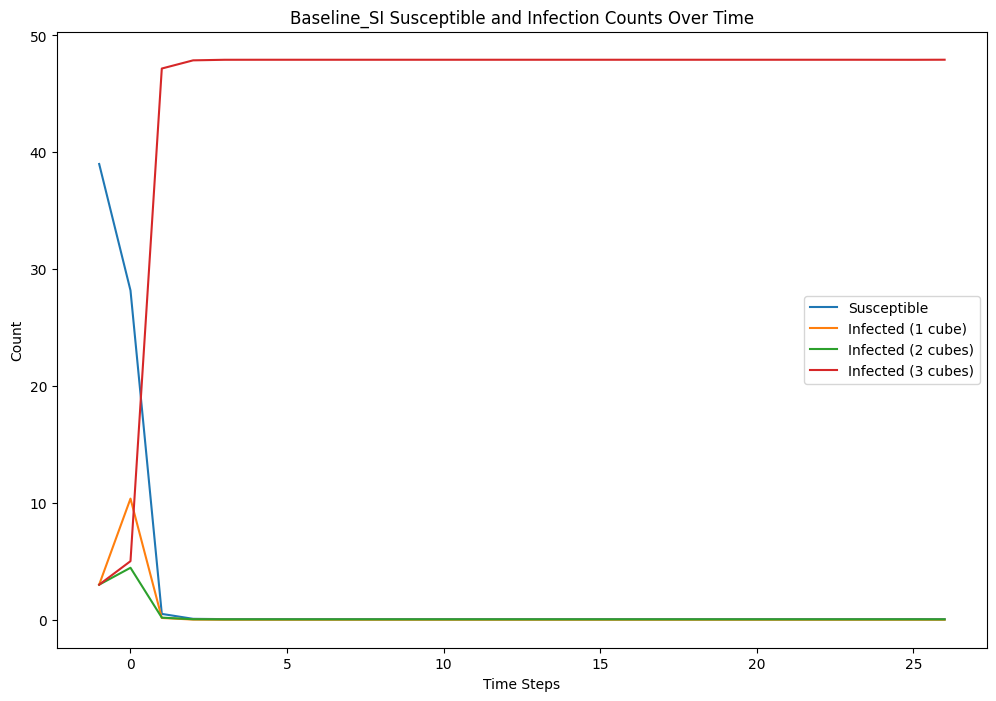

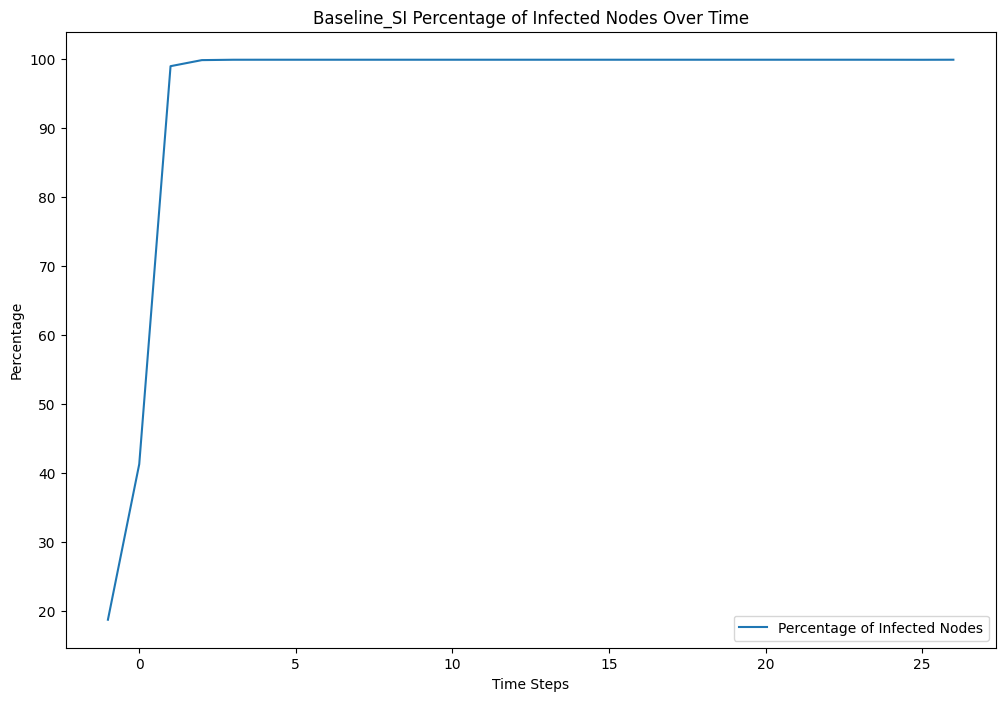

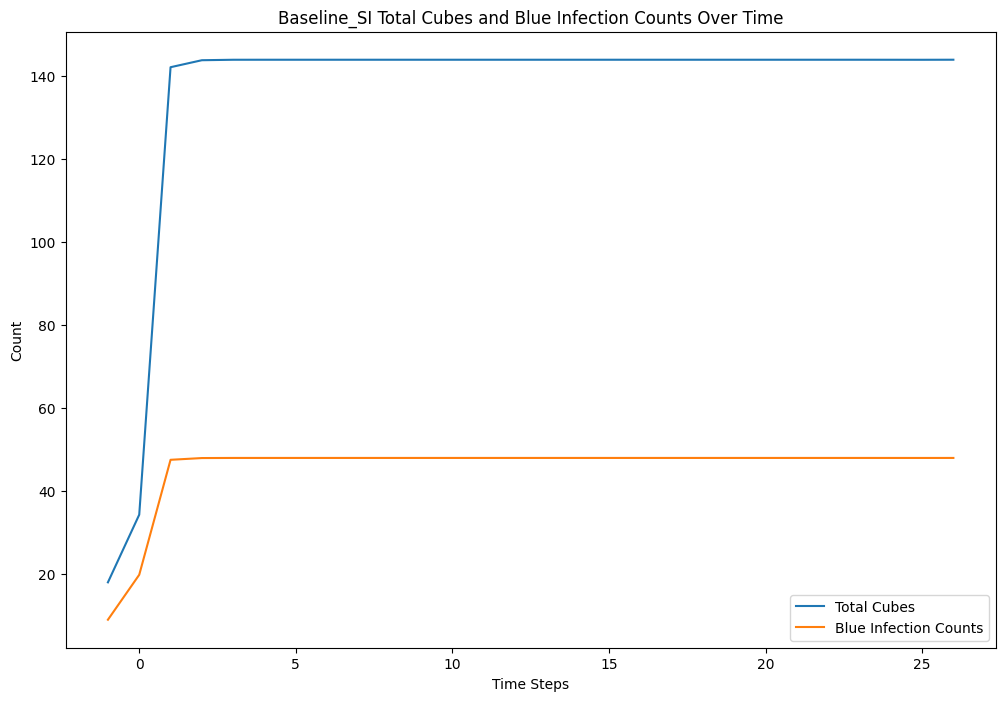

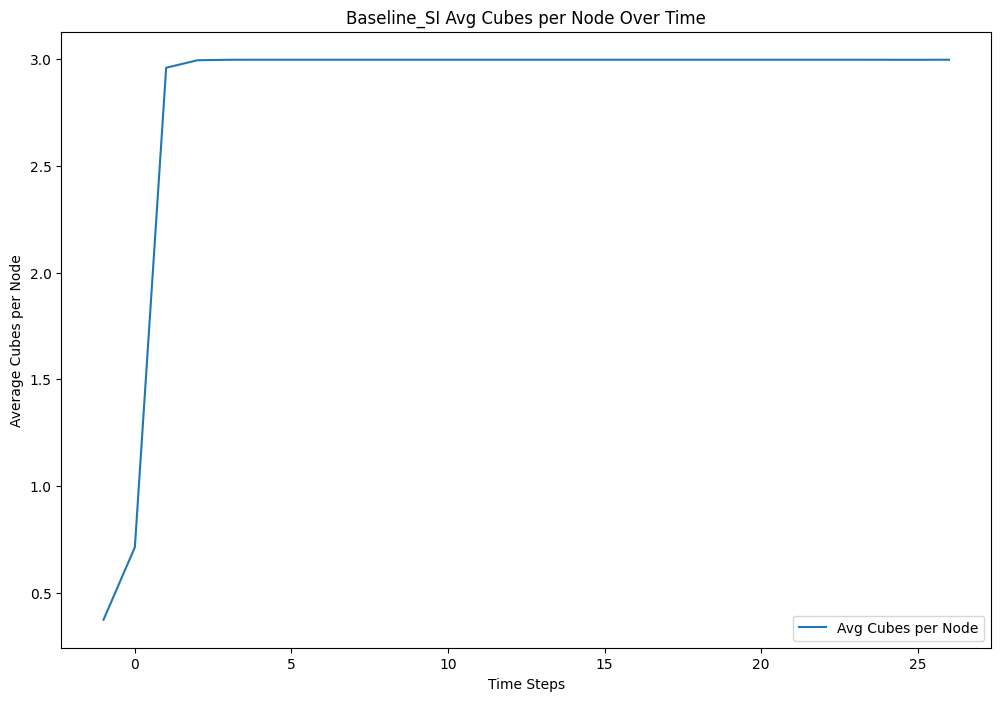

In [21]:
#@title Baseline
df = pd.read_csv('Baseline_SI.csv')

folder_name = "BaselineStats"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)


avg_susceptible = calculate_avg_susceptible(df)
avg_infected_1, avg_infected_2, avg_infected_3 = calculate_avg_infected(df)
avg_percentage_infected = calculate_avg_percentage_infected(df)
avg_total_cubes, avg_blue_infection = calculate_avg_cubes_and_blue_infection(df)
avg_cubes_per_node = calculate_avg_cubes_per_node(df)

# Plot statistics
# Plot Susceptible and Infection Counts Over Time
plt.figure(figsize=(12, 8))
plt.plot(avg_susceptible.index, avg_susceptible.values, label='Susceptible')
plt.plot(avg_infected_1.index, avg_infected_1.values, label='Infected (1 cube)')
plt.plot(avg_infected_2.index, avg_infected_2.values, label='Infected (2 cubes)')
plt.plot(avg_infected_3.index, avg_infected_3.values, label='Infected (3 cubes)')
plt.xlabel('Time Steps')
plt.ylabel('Count')
plt.title('Baseline_SI Susceptible and Infection Counts Over Time')
plt.legend()
plt.savefig(os.path.join(folder_name, f'Baseline_SI_susceptible_and_infection_counts.png')) # Save the plot
plt.show()
plt.close()

# Plot Percentage of Infected Nodes over time steps
plt.figure(figsize=(12, 8))
plt.plot(avg_percentage_infected.index, avg_percentage_infected.values, label='Percentage of Infected Nodes')
plt.xlabel('Time Steps')
plt.ylabel('Percentage')
plt.title('Baseline_SI Percentage of Infected Nodes Over Time')
plt.legend()
plt.savefig(os.path.join(folder_name, f'Baseline_SI_percentage_of_infected_nodes.png')) # Save the plot
plt.show()
plt.close()

# Plot Total Cubes and Blue Infection counts over time steps
plt.figure(figsize=(12, 8))
plt.plot(avg_total_cubes.index, avg_total_cubes.values, label='Total Cubes')
plt.plot(avg_blue_infection.index, avg_blue_infection.values, label='Blue Infection Counts')
plt.xlabel('Time Steps')
plt.ylabel('Count')
plt.title(f'Baseline_SI Total Cubes and Blue Infection Counts Over Time')
plt.legend()
plt.savefig(os.path.join(folder_name, f'Baseline_SI_total_cubes_and_blue_infection_counts.png')) # Save the plot
plt.show()
plt.close()

# Plot Avg Cubes per Node over time steps
plt.figure(figsize=(12, 8))
plt.plot(avg_cubes_per_node.index, avg_cubes_per_node.values, label='Avg Cubes per Node')
plt.xlabel('Time Steps')
plt.ylabel('Average Cubes per Node')
plt.title(f'Baseline_SI Avg Cubes per Node Over Time')
plt.legend()
plt.savefig(os.path.join(folder_name, f'Baseline_SI_avg_cubes_per_node.png')) # Save the plot
plt.show()
plt.close()

In [ ]:
#@title Baseline lose condition heatmap

baseline_df = pd.read_csv('Baseline_SI.csv')

# Initialize a 2D array to store probabilities
# 0 Actions for baseline
probabilities = np.zeros((len([0]), len(epidemic_cards)))  # Swapping dimensions

# Iterate over all combinations of 'no_epidemic' and 'k_actions'
for i, no_epi in enumerate(epidemic_cards):
    for j, k_act in enumerate([0]):  # Adjusted indices
        # Filter the DataFrame based on the current combination
        filtered_df = baseline_df[(baseline_df['no_epidemic'] == no_epi) & (baseline_df['k_actions'] == k_act)]

        # Initialize counter for this combination
        count = 0

        # Iterate over each run in the filtered DataFrame
        for _, run in filtered_df.groupby('run'):
            # Calculate the total number of cubes for each timestep in the run
            total_cubes_per_timestep = run['infection_1_nodes'] + 2 * run['infection_2_nodes'] + 3 * run['infection_3_nodes']
            # Check if any timestep within the run has 96 or more cubes
            if (total_cubes_per_timestep >= 96).any():
                count += 1

        # Calculate the probability
        probability = count / 10000

        # Store the probability in the 2D array
        probabilities[j, i] = probability

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(probabilities, cmap='coolwarm', annot=True, xticklabels=epidemic_cards, yticklabels=[0])  # Adjusted labels
plt.xlabel('no_epidemic')  # Adjusted label
plt.ylabel('k_actions')  # Adjusted label
plt.title('Probability of hitting 96 or more cubes')
#plt.savefig((f'Baseline_OneColor_Probability_of_hitting_96_or_more_cubes.png'))
plt.show()

In [ ]:
#@title 8 or more outbreaks lose condition boxplot

def calculate_8_outbreaks_heatmap(df, setup_name, condition_column, threshold):
    # Define the unique values of 'no_epidemic' and 'k_actions'
    unique_no_epidemics = sorted(df['no_epidemic'].unique())
    unique_k_actions = sorted(df['k_actions'].unique())

    # Initialize a 2D array to store probabilities
    probabilities = np.zeros((len(unique_k_actions), len(unique_no_epidemics)))  # Swapping dimensions

    # Iterate over all combinations of 'no_epidemic' and 'k_actions'
    for i, no_epi in enumerate(unique_no_epidemics):
        for j, k_act in enumerate(unique_k_actions):  # Adjusted indices
            # Filter the DataFrame based on the current combination
            filtered_df = df[(df['no_epidemic'] == no_epi) & (df['k_actions'] == k_act)]

            # Initialize counter for this combination
            count = 0

            # Iterate over each run in the filtered DataFrame
            for _, run in filtered_df.groupby('run'):
                # Check if any timestep within the run meets the condition
                if (run[condition_column] >= threshold).any():
                    count += 1

            # Calculate the probability
            probability = count / 100

            # Store the probability in the 2D array
            probabilities[j, i] = probability

    # Create the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(probabilities, cmap='coolwarm', annot=True, xticklabels=unique_no_epidemics, yticklabels=unique_k_actions)  # Adjusted labels
    plt.xlabel('no_epidemic')  # Adjusted label
    plt.ylabel('k_actions')  # Adjusted label
    plt.title(f'Probability of hitting {threshold} or more {condition_column} for {setup_name} setup')
    #plt.savefig((f'{setup_name}_OneColor_Heatmap_8_or_more_Outbreaks.png'))
    plt.show()

In [ ]:
baseline_df = pd.read_csv('Baseline_SI.csv')

# Define the setup name
setup_name = "Baseline"

# Call the function with your baseline_df and setup_name
calculate_8_outbreaks_heatmap(baseline_df, setup_name, "outbreaks", 8)

In [25]:
#@title Baseline creation
run = 1
data = []  # Initialize all statistics list
for k_action in k_actions_range:
    if k_action == 0:
        for epidemic in epidemic_cards:
            for num_simulation  in range(num_simulations):
                model = initialize_pandemic_model(Graph_gameboard, "baseline", k_action, epidemic, 3)

                # 48 City cards + epidemics
                # per turn a player can draw 2 cards
                num_steps = math.ceil((48 + epidemic) / 2)  # Round up to the next integer
                stats = simulate_pandemic(model, num_steps, run)
                data.extend(stats)
                run += 1

# Creating DataFrame
df = pd.DataFrame(data)

# Saving DataFrame to CSV file
df.to_csv('Baseline_SI_Without_Outbreaks.csv', index=False)

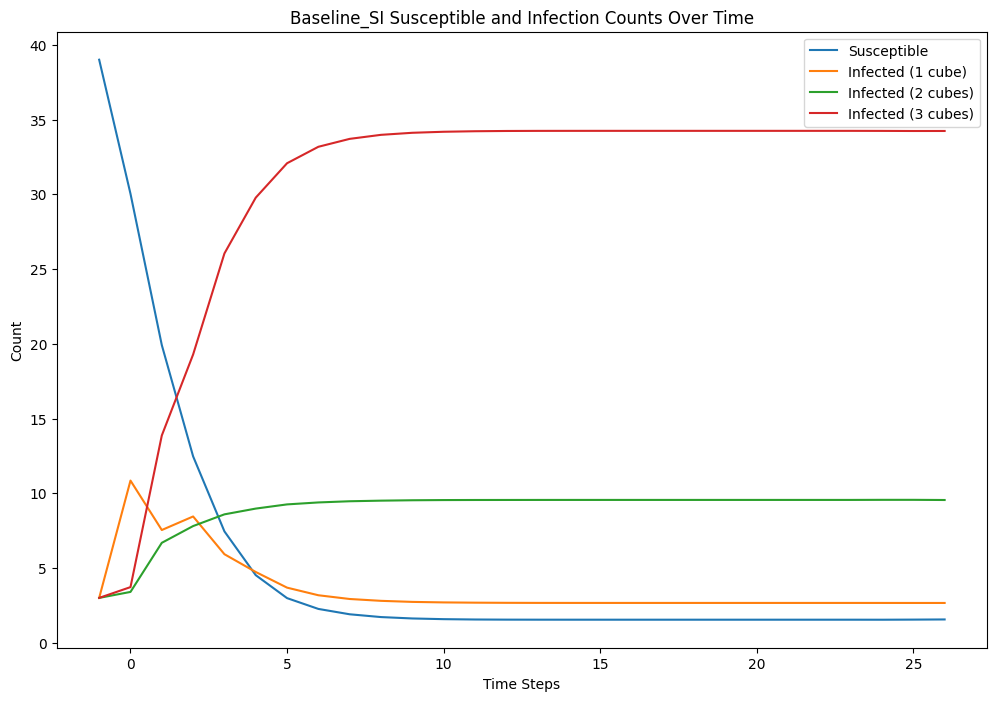

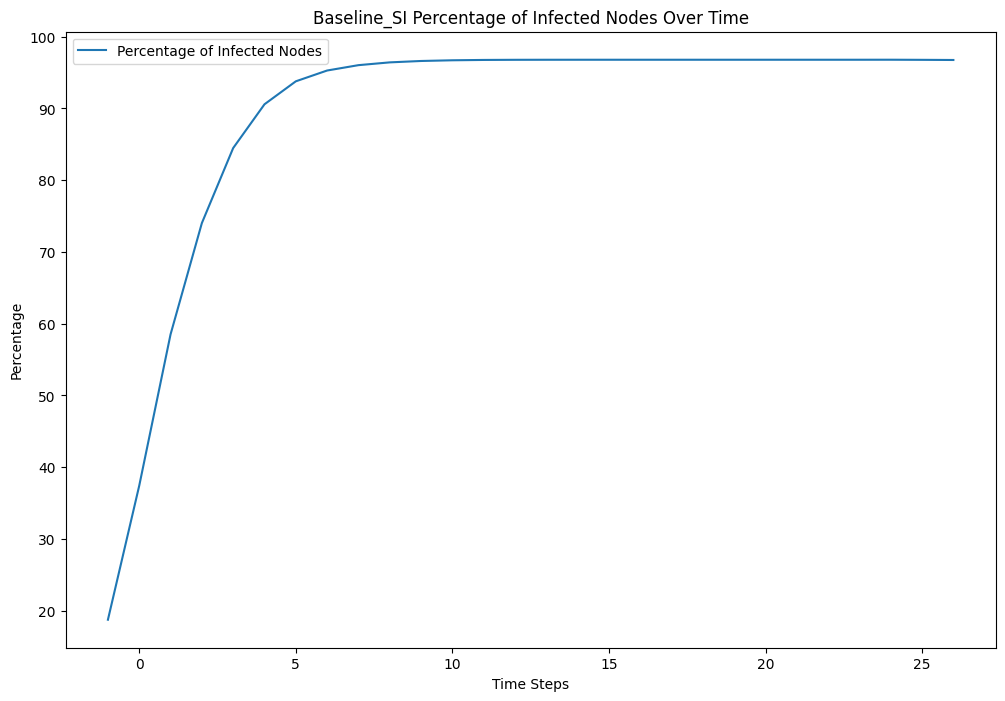

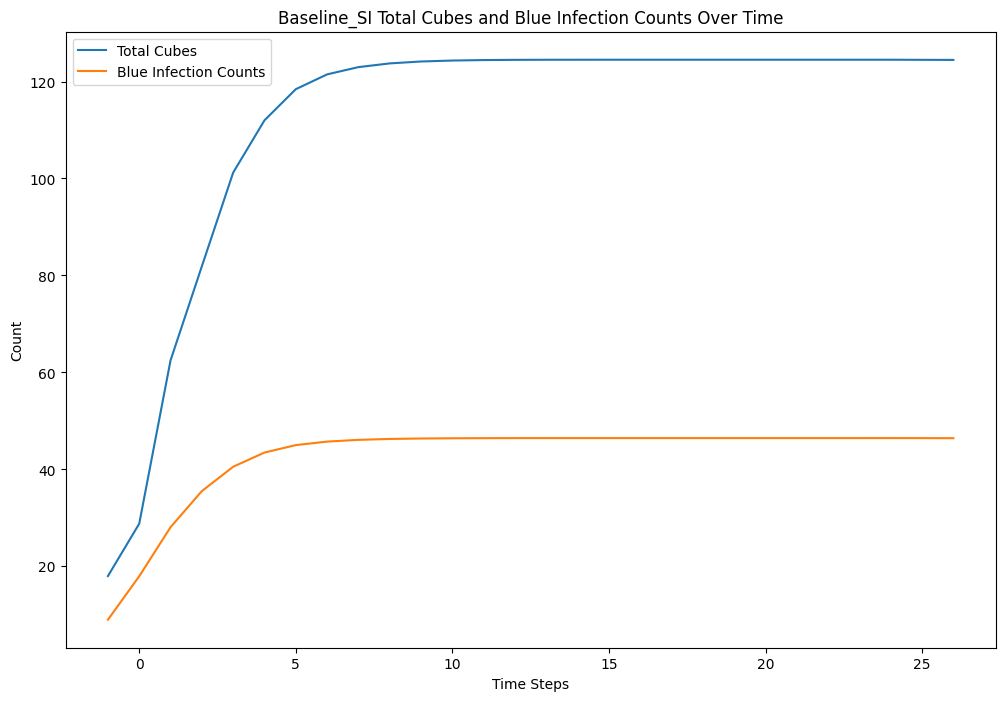

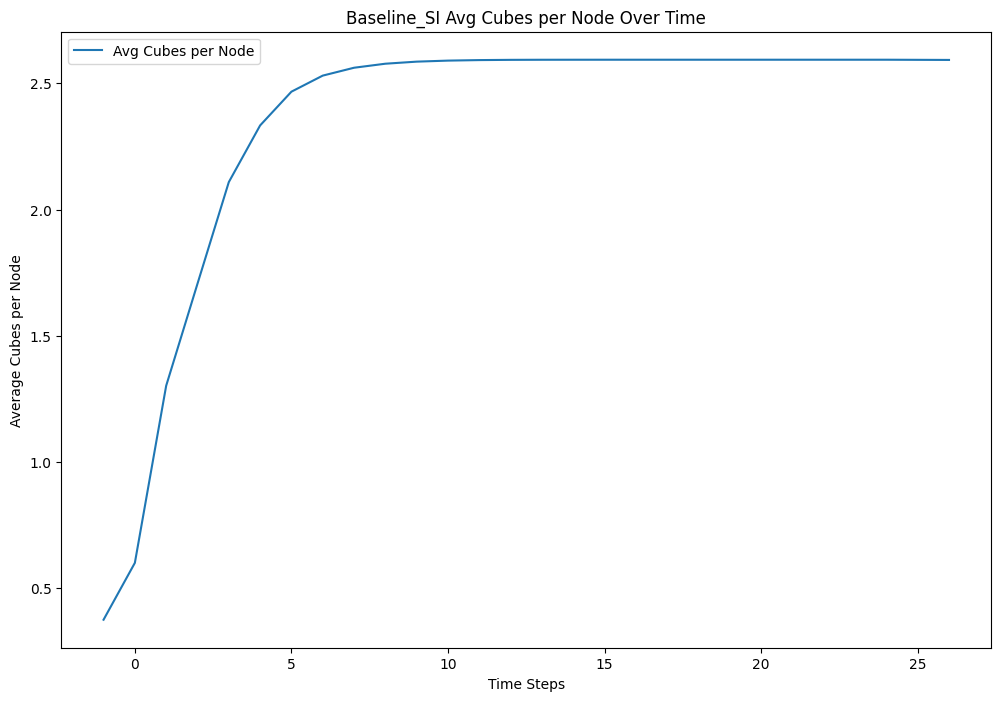

In [26]:
#@title Baseline
df = pd.read_csv('Baseline_SI_Without_Outbreaks.csv')

folder_name = "BaselineStats"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)


avg_susceptible = calculate_avg_susceptible(df)
avg_infected_1, avg_infected_2, avg_infected_3 = calculate_avg_infected(df)
avg_percentage_infected = calculate_avg_percentage_infected(df)
avg_total_cubes, avg_blue_infection = calculate_avg_cubes_and_blue_infection(df)
avg_cubes_per_node = calculate_avg_cubes_per_node(df)

# Plot statistics
# Plot Susceptible and Infection Counts Over Time
plt.figure(figsize=(12, 8))
plt.plot(avg_susceptible.index, avg_susceptible.values, label='Susceptible')
plt.plot(avg_infected_1.index, avg_infected_1.values, label='Infected (1 cube)')
plt.plot(avg_infected_2.index, avg_infected_2.values, label='Infected (2 cubes)')
plt.plot(avg_infected_3.index, avg_infected_3.values, label='Infected (3 cubes)')
plt.xlabel('Time Steps')
plt.ylabel('Count')
plt.title('Baseline_SI Susceptible and Infection Counts Over Time')
plt.legend()
plt.savefig(os.path.join(folder_name, f'Baseline_SI_susceptible_and_infection_counts.png')) # Save the plot
plt.show()
plt.close()

# Plot Percentage of Infected Nodes over time steps
plt.figure(figsize=(12, 8))
plt.plot(avg_percentage_infected.index, avg_percentage_infected.values, label='Percentage of Infected Nodes')
plt.xlabel('Time Steps')
plt.ylabel('Percentage')
plt.title('Baseline_SI Percentage of Infected Nodes Over Time')
plt.legend()
plt.savefig(os.path.join(folder_name, f'Baseline_SI_percentage_of_infected_nodes.png')) # Save the plot
plt.show()
plt.close()

# Plot Total Cubes and Blue Infection counts over time steps
plt.figure(figsize=(12, 8))
plt.plot(avg_total_cubes.index, avg_total_cubes.values, label='Total Cubes')
plt.plot(avg_blue_infection.index, avg_blue_infection.values, label='Blue Infection Counts')
plt.xlabel('Time Steps')
plt.ylabel('Count')
plt.title(f'Baseline_SI Total Cubes and Blue Infection Counts Over Time')
plt.legend()
plt.savefig(os.path.join(folder_name, f'Baseline_SI_total_cubes_and_blue_infection_counts.png')) # Save the plot
plt.show()
plt.close()

# Plot Avg Cubes per Node over time steps
plt.figure(figsize=(12, 8))
plt.plot(avg_cubes_per_node.index, avg_cubes_per_node.values, label='Avg Cubes per Node')
plt.xlabel('Time Steps')
plt.ylabel('Average Cubes per Node')
plt.title(f'Baseline_SI Avg Cubes per Node Over Time')
plt.legend()
plt.savefig(os.path.join(folder_name, f'Baseline_SI_avg_cubes_per_node.png')) # Save the plot
plt.show()
plt.close()